## LEAD Rover Data Tutorial


**Tutorial**: This tutorial consists of the steps in Python to extract, visualize and save data *(imagery, LiDAR)* files in the form of rosbags captured by the Juno Rover on a replication of a lunar mission.<br>
**Mission & Instrument**: Lunar Exploration Analogue Deployment (LEAD), Juno Rover <br>
**System Requirements**: Python 3.8.8 <br>
**Tutorial Level**: Intermediate <br>

***
**MIT License** <br>
Copyright (c) His Majesty the King in Right of Canada, as represented by the Canadian Space Agency, 2023. <br>
Droit d’auteur (c) Sa Majesté le Roi du chef du Canada, représentée par l'Agence Spatiale Canadienne, 2023.<br>

For more information, please refer to the *License.txt* file. 


***
 **Background Information** 

In the time period between 2017-2019, The Canadian Space Agency (CSA) partnered with the European Space Agency (ESA) to conduct a series of field tests to replicate scenarios of a lunar sample return mission. This was to gain knowledge and hands-on experience to prepare for the next chapter of space exploration: sending human beings to more distant destinations like the Moon and Mars. <br>

This mission simulation was conducted using the CSA's Juno Rover: a rugged, all-terrain rover. These field tests were performed in three phases at two locations: a rock quarry and the CSA Analogue Terrain (also known as the Mars Yard) in Quebec. The rover was operated by teams based in Saint-Hubert (Quebec) and Germany to recreate the difficulty of long-distance communications. <br>

This project was split as follows: <br>
1. **LEAD/HOPE:** This focused on having trained operators carry out sample return missions. It took place over five days in October 2017 and four days in June 2019. 
2. **LEAD Rover Metrics Gathering Experiment (LRMGE):** This part of the mission had six teams in June 2019 operate the rover along a pre-defined itinerary to gather metrics on rover driving performance.
3. **LEAD Permanently Shadowed Region(PSR):** Lastly, this part focused on rover driving tasks under dark lightning conditions emulating operations in a PSR. 

The dataset analyzed in this tutorial is from the LEAD (PSR) phase and took place in September 2019. It is in the form of a rosbag and provides imagery, LiDAR data, and the estimated pose of the rover. <br>

You can read more about the mission here: <br>
**Juno Rover:** https://www.asc-csa.gc.ca/eng/multimedia/search/image/7824<br>
**LEAD:** https://www.asc-csa.gc.ca/eng/rovers/mission-simulations/lunar-exploration-analogue-deployment.asp<br>
$\;\;\;\;\;\;\;\;$ https://www.hou.usra.edu/meetings/isairas2020fullpapers/pdf/5015.pdf

 ***

**Dataset Download:** <br>
The dataset, in the form of a rosbag, can be downloaded from the Open Data Portal: <br>
https://donnees-data.asc-csa.gc.ca/dataset/9151430-4v0p-4t5c-468vnhj714ao64

In [1]:
#Required imports 
import os, imageio, io, datetime, csv
import numpy as np
import rosbag, bagpy
import pandas as pd 
import open3d as o3d 
from sensor_msgs.point_cloud2 import read_points 
from matplotlib import pyplot as plt 
import geopandas, folium, base64
from folium import IFrame
import utm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


***
### Opening a ROSBAG File
***

In [2]:
#Opening rosbag file 
bagpy_bag = bagpy.bagreader('LEAD_delayed_2019-09-25-19-00-01-filtered.bag')
bag = rosbag.Bag('LEAD_delayed_2019-09-25-19-00-01-filtered.bag')

[INFO]  Data folder LEAD_delayed_2019-09-25-19-00-01-filtered already exists. Not creating.



>Let's take a first look at the contents of the rosbag.


In [3]:
#List of topics & types of messages
print(bagpy_bag.topic_table)

                                               Topics  \
0               /delayed/artemisJr/centre/camera_info   
1   /delayed/artemisJr/centre/image_rect_color/com...   
2           /delayed/artemisJr/imageData/centrePtzCam   
3                 /delayed/artemisJr/left/camera_info   
4   /delayed/artemisJr/left/image_rect_color/compr...   
5   /delayed/artemisJr/right/image_rect_color/comp...   
6      /delayed/evo/left_polled/image_rect/compressed   
7     /delayed/evo/right_polled/image_rect/compressed   
8                     /delayed/lowrate_scanner/points   
9                                  /delayed/tf_static   
10  /delayed/trt/ws_left_polled/image_rect_color/c...   
11  /delayed/trt/ws_right_polled/image_rect_color/...   
12                     /delayed/trt_localization/pose   
13              /delayed/trt_stitcher/pano/compressed   

                          Types  Message Count  Frequency  
0        sensor_msgs/CameraInfo           1338   0.999854  
1   sensor_msgs/Compress

>We start by extracting sensor_msgs/CameraInfo and converting them to csv files. This contains camera calibration information of the centre and left camera.

In [4]:
#Decoding data by topic & converting to dataframe  (Camera Info & Localization)
Camera_info_centre_msg = bagpy_bag.message_by_topic('/delayed/artemisJr/centre/camera_info')
df_CAMERA_CENTRE = pd.read_csv(Camera_info_centre_msg) #Centre camera calibration

Camera_info_left_msg = bagpy_bag.message_by_topic('/delayed/artemisJr/left/camera_info')
df_CAMERA_LEFT = pd.read_csv(Camera_info_left_msg) #Left camera calibration

df_CAMERA_CENTRE.head(5)

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,height,width,distortion_model,D_0,D_1,...,P_9,P_10,P_11,binning_x,binning_y,roi.x_offset,roi.y_offset,roi.height,roi.width,roi.do_rectify
0,1.569452e+09,1,1569452246,215621948,/axis_camera,480,640,plumb_bob,-0.207038,0.033157,...,0.0,1.0,0.0,0,0,0,0,0,0,False
1,1.569455e+09,2,1569454506,610065937,/axis_camera,480,640,plumb_bob,-0.207038,0.033157,...,0.0,1.0,0.0,0,0,0,0,0,0,False
2,1.569455e+09,3,1569455429,176963090,/axis_camera,480,640,plumb_bob,-0.207038,0.033157,...,0.0,1.0,0.0,0,0,0,0,0,0,False
3,1.569455e+09,4,1569455430,179078102,/axis_camera,480,640,plumb_bob,-0.207038,0.033157,...,0.0,1.0,0.0,0,0,0,0,0,0,False
4,1.569455e+09,5,1569455431,184009075,/axis_camera,480,640,plumb_bob,-0.207038,0.033157,...,0.0,1.0,0.0,0,0,0,0,0,0,False


*A glance of the first 5 rows of df_CAMERA_CENTRE*

***
### Extracting and visualizing point cloud data (PCD)
***

Let's now extract sensor_msgs/PointCloud2 and visualize them. The 3D point cloud data is from the 3D scanner and is used for navigation (e.g., terrain assessment, path-planning). The resulting point cloud is voxelized and points that fall on the rover are removed.

In [5]:
#Extracting Point Cloud files from .bag file & converting them to csv files 
if __name__ == "__main__":
    path = './csv' #Path for csv folder 
    if not os.path.exists(path): #Check whether directory already exists, create otherwise
        os.mkdir(path)
        print("Folder %s created!" % path)
    else:
        print("Folder %s already exists" % path)
        
    for msg in bag:
        if  msg[0] == "/delayed/lowrate_scanner/points":
            print(msg[2])
            t = datetime.datetime.fromtimestamp(msg[2].to_sec()).strftime("%Y-%m-%d-%H_%M_%S")
            name = "csv/{0}-{1}.csv".format(msg[0].replace("/","_"),t)
            print("Saving to " + name)
            with open(name,"w") as f:
                # Read the points
                for point in read_points(msg[1]):
                    print("{0:.4f}, {1:.4f}, {2:.4f}".format(point[0],point[1],point[2]), file=f)
                f.close()

In [7]:
path = os.getcwd() + '\\csv'
file_list = []
for root, dirs, files in os.walk(path):
    for file in files:
            file_list.append(os.path.join(root,file))       

In [7]:
#Loading point cloud data and creating a point cloud object 
pcd_data = []
for file in file_list:
        name = file[-54:-4]
        data_csv = pd.read_csv(file)
        data_array = np.array(data_csv) #Converting to numpy array 
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data_array)
        pcd_data.append(pcd)
        o3d.visualization.draw_geometries([pcd])
        #o3d.io.write_point_cloud(name + ".pcd", pcd)  #uncomment to save file 
        del pcd


*Visualizing one point cloud file*

<img src="1-PCD.png" width= 50%>

>Several other techniques are potentially useful in the visualization of point cloud data. This includes techniques such as development of a convex hull (the enclosure of all points within a space), visualization of the voxel grid, or visualization of an octree, all of which are shown below.

In [10]:
i = 0
pcd_dbscan =  pcd_data[i] #update i as needed 

dist_list = []
#Creating a kd-tree for fast retreival of nearest neighbors
pcd_tree = o3d.geometry.KDTreeFlann(pcd_dbscan)

for i in range(len(np.asarray(pcd_dbscan.points))): 
    #For each point in the point cloud returns the 3 nearest neighbors distances (4 is used since also returns self)
    [k, _, dist] = pcd_tree.search_knn_vector_3d(pcd_dbscan.points[i], 4)

    for j in range(1, k):
        dist_list.append(dist[j])

#Sorting distances
dist_list.sort()

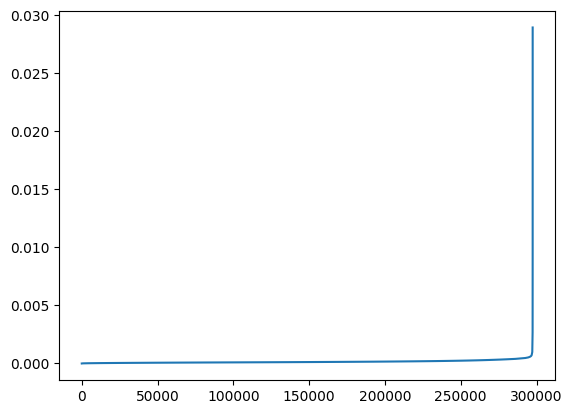

In [9]:
#Plotting graph
dist_arr = np.asarray(dist_list)
plt.plot(dist_arr)

In [11]:
min_points = 20
eps = 0.1 #from above graph

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd_dbscan.cluster_dbscan(eps = eps, min_points = min_points, print_progress=True)) # dbscan function
    
max_label = labels.max()

# setting a different color for each cluster with no clusters equaling black
colors = plt.get_cmap("gist_ncar")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0

pcd_dbscan.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd_dbscan])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 1


<img src="2-DBSCAN.png"  width= 50%>

In [ ]:
#Other visualizations
i = 0
pcd_processed = pcd_data[i]

pcd_processed.scale(1 / np.max(pcd_data[i].get_max_bound() - pcd_data[i].get_min_bound()), center=pcd_processed.get_center())

# assigning a random color to each point in the point cloud 
pcd_processed.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(len(pcd_processed.points), 3)))

# determination of the convex hull including edges of the polygon
conv_hull, _  = pcd_processed.compute_convex_hull()
conv_hull.compute_vertex_normals() # edges
o3d.visualization.draw_geometries([conv_hull])

# displaying the voxel grid
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_processed, voxel_size= 0.01) #voxel size correlates to grid
o3d.visualization.draw_geometries([voxel_grid])

# displaying octree
octree = o3d.geometry.Octree(max_depth=4) # depth specifies the level of detailed stored
octree.convert_from_point_cloud(pcd_processed, size_expand=0.01)
o3d.visualization.draw_geometries([octree])

*The same point cloud file in different vizualizations*


<table><tr>
<td> <img src="3-CONVEXHull.png" width: 50% > </td>
<td> <img src="4-VOXELGrid.png" width: 50% > </td>
<td> <img src="5-OCTREE.png" width: 50% > </td> 
</tr></table>

***
### Extracting and vizualizing compressed images
***

We can now look at the remaining files in the rosbag which are of the type sensor_msgs/CompressedImage. There are different topics in the bag and you can replace the topic name, depending on the images you wish to extract.For the purpose of this tutorial, we will be extracting and visualizing compressed images from the topic: */delayed/evo/left_polled/image_rect/compressed.* <br> Each message contains an image and a timestamp so we will extract both and save them.


In [5]:
#Create a list to save images and timestamps of desired topic. 
Image_Rect_Left_Polled = []
Image_Rect_Left_Polled_timestamps = []

In [6]:
#Extracting raw compressed image data & saving to specific list (Images & TimeStamp)
if __name__ == "__main__":
    for msg in bag:
            if  msg[0] == "/delayed/evo/left_polled/image_rect/compressed": #Replace with desired topic
                timestamp = datetime.datetime.fromtimestamp(msg[2].to_sec()).strftime("%Y_%m_%d-%H_%M_%S") #Extract and transform timestamp
                Image_Rect_Left_Polled_timestamps.append(timestamp) #Replace list with corresponding topic list
                raw_data = io.BytesIO(msg[1].data) #Extract raw image data from .bag file
                image_data = imageio.v2.imread(raw_data)   
                Image_Rect_Left_Polled.append(image_data) #Replace list with corresponding topic
                

Folder ./Images already exists
This picture was taken on: 2019_09_25-20_17_49


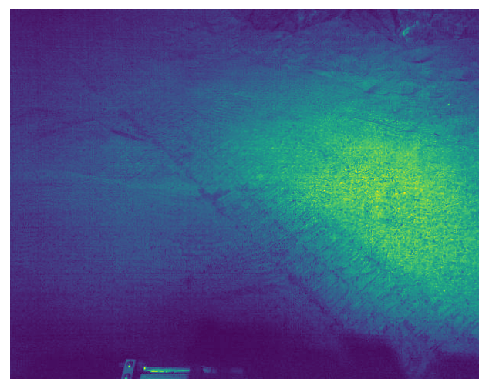

In [7]:
#Visualize & save compressed images from list
path_image = './Images' #Path for new folder "Images"
    
#Check whether directory already exists
if not os.path.exists(path_image):
    os.mkdir(path_image)
    print("Folder %s created!" % path_image)
else:
    print("Folder %s already exists" % path_image)
        
os.chdir(path_image)

i = 0
for img in Image_Rect_Left_Polled: #replace list with desired topic
    plt.imshow(img, interpolation='nearest')
    plt.axis("off")
    timestamp = Image_Rect_Left_Polled_timestamps[i]
    plt.savefig("Image_Rect_Left_Polled "+ str(timestamp) +".jpg") #Change name to corresponding topic
    i += 1
print("This picture was taken on: " + timestamp)    
os.chdir('../') #Change directory back

>Another file in the rosbag is of type geometry_msgs/PoseStamped. It contains the location of the rover along with all the timestamps. <br>
 Let's retrieve these timestamps and format them for better readability.

In [8]:
#Get time stamps from all images and scans
timestamps_total = []
for msg in bag:
    if  msg[0] == "/delayed/trt_localization/pose":
        time = datetime.datetime.fromtimestamp(msg[2].to_sec()).strftime("%Y_%m_%d-%H_%M_%S")
        timestamps_total.append(time)

#Time stamps format updated and new csv file created 
location_csv = pd.read_csv(os.getcwd() + "\\LEAD_delayed_2019-09-25-19-00-01-filtered\\delayed-trt_localization-pose.csv") 
location_csv['TimeStamps'] = timestamps_total
location_csv.to_csv('Localization_TimeStamp_Updated.csv') 
location_csv.iloc[:,-8:].head(10) 

,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w,TimeStamps
0,5.821482,70.038535,-0.3657,0.000080,0.013657,0.027661,0.999524,2019_09_25-16_00_01
1,5.821482,70.038535,-0.3657,0.000099,0.013670,0.027662,0.999524,2019_09_25-16_00_02
2,5.821482,70.038535,-0.3657,0.000085,0.013695,0.027679,0.999523,2019_09_25-16_00_03
3,5.821482,70.038535,-0.3657,0.000064,0.013680,0.027696,0.999523,2019_09_25-16_00_04
4,5.821482,70.038535,-0.3657,0.000072,0.013689,0.027678,0.999523,2019_09_25-16_00_05
5,5.821482,70.038535,-0.3657,0.000068,0.013683,0.027708,0.999522,2019_09_25-16_00_06
6,5.821482,70.038535,-0.3657,0.000083,0.013680,0.027713,0.999522,2019_09_25-16_00_07
7,5.821482,70.038535,-0.3657,0.000098,0.013674,0.027708,0.999523,2019_09_25-16_00_08
8,5.821482,70.038535,-0.3657,0.000094,0.013669,0.027708,0.999523,2019_09_25-16_00_09
9,5.821482,70.038535,-0.3657,0.000116,0.013668,0.027691,0.999523,2019_09_25-16_00_10


*A glance at the first 10 rows of selected columns*

***
### Mapping Juno Rover's path
***

Our next step is to map Juno Rover's path over the Mars Yard.We will first extract the positions of the rover from the csv file and convert it to a latitude and longitude format. 
> **We take the origins of the Mars Yard as (45.5182069858,-73.3939063839).In this case, we project the x and y positions given, from the origin.** 

In [9]:
#Converting mars yard origin to utm
mars_origin = utm.from_latlon(45.5182069858,-73.3939063839)
print(mars_origin)

(625438.2348290744, 5041773.785209548, 18, 'T')


In [10]:
gdf = geopandas.GeoDataFrame(
    location_csv, geometry=geopandas.points_from_xy(location_csv["pose.position.x"], location_csv["pose.position.y"]))
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry]

i = 0
for i in range(0,15951):
    test_x = geo_df_list[i][0]+625438.2348290744
    geo_df_list[i][0] = test_x
    test_y = 5041773.785209548 - geo_df_list[i][1]
    geo_df_list[i][1] = test_y
    i += 1

In [11]:
#Converting all rover positions to latitude & longitude and converting csv file to dictonary
new_coord = []
lat = []
lon = []

i = 0
for i in range(0,15951):
    coord = utm.to_latlon(geo_df_list[i][0], geo_df_list[i][1], 18, northern = True)
    new_coord.append(coord)
    lat.append(coord[0])
    lon.append(coord[1])
    i += 1

location_csv['Lat'] = lat
location_csv['Lon'] = lon
location_csv.to_csv('Localization_Location_Updated.csv') 
location_csv

with open('Localization_Location_Updated.csv') as f:
    reader = csv.DictReader(f)
    Timestamp_csv_dict = [row for row in reader]

In [12]:
location_csv.iloc[:,-3:].head(5) 

,TimeStamps,Lat,Lon
0,2019_09_25-16_00_01,45.518142,-73.393011
1,2019_09_25-16_00_02,45.518142,-73.393011
2,2019_09_25-16_00_03,45.518142,-73.393011
3,2019_09_25-16_00_04,45.518142,-73.393011
4,2019_09_25-16_00_05,45.518142,-73.393011


*Latitude and Longitude of the rover with the respective timestamp*

>Since all of our images have a timestamp attached, we can cross-reference the timestamp in our Timestamp_csv_dict and get a position of the rover at the time the image was captured.

In [13]:
#Cross references timestamps & returns image position (lat and lon)
def get_position(timestamp):
    for file in Timestamp_csv_dict:
        if timestamp == file['TimeStamps']:
            x_position = file['Lat']
            y_position = file['Lon']
            return (x_position, y_position)

>We now have all the information needed to  plot a map of the rover's path. 

In [ ]:
m = folium.Map(location=[45.5182069858,-73.3939063839], zoom_start=17)
centred_polyline=folium.PolyLine(locations=new_coord,weight=5)
m.add_child(centred_polyline)

<img src="6-MAP.png" > 

>We can also add pop-ups to show where the rover was at the time a specific image (or list of images) was taken. We are still using images from the topic */delayed/evo/left_polled/image_rect/compressed.* 

In [15]:
image_list = []
path_images = os.getcwd() +"\\Images"
for root, dirs, files in os.walk(path_images):
    for file in files:
            image_list.append(os.path.join(root,file)) 

In [16]:
i = 0
for image in image_list:
    encoded = base64.b64encode(open(image,'rb').read())
    name = (image[-46:-4]).replace("_"," ") #Retrieving image name 
    html = (str(name) + '<img src="data:image/png;base64,{}">').format
    iframe = IFrame(html(encoded.decode('UTF-8')), width=650, height=550)
    popup = folium.Popup(iframe, max_width=650)
    loc = get_position(image[-23:-4]) #Cross-referencing timestamp to get lat & lon
    folium.Marker(location=[loc[0],loc[1]], tooltip=html, popup = popup, lazy = True,
              icon=folium.Icon(color = 'blue')).add_to(m)
    if len(image_list) > 7000:
        i += 500
    if len(image_list) > 1000 and len(image_list) < 7000:
        i += 100
    else:
        i += 1

<img src="7-MAP_Images.png" > 


*Every image contains its topic and the date-time at which it was captured.*


<img src="6-MAP.jpeg" width=100% > 


*Image that pops up afer clicking on a icon*

In [29]:
#Close rosbag 
bag.close()